In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
import csv
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import os
import dask


def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    # Create an NMF model with specified parameters
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    
    # Fit the NMF model to the input data
    NMF_data= NMF_model.fit_transform(Real_Data)
    
    # Extract the factorized matrix components
    fit_compos = NMF_model.components_
    
    # Calculate the reconstruction error of the model
    Q = np.array(NMF_model.reconstruction_err_)*100
    
    # Suppress warnings from the library
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # Return the reconstruction error, factorized matrix components, and transformed data
    return Q, fit_compos, NMF_data

def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000):
    """ 
    This function performs NMF (Non-negative Matrix Factorization) on the input data, Real_Data.
    The function takes in the following parameters:
    Real_Data: the input data to be factorized
    init: the initial guess of the factorization (default is None)
    solver: the solver to be used in the factorization (default is 'cd' - Coordinate Descent)
    beta_loss: the beta-divergence loss function to be used (default is 'frobenius')
    itear: the number of iterations to perform in the factorization (default is 1000)

    The function returns a tuple of two items:
        1. A pandas dataframe of the NMF components
        2. The reconstructed NMF data
        
    The function uses Dask for parallel computing, and opens a web browser to display the Dask dashboard. 
    """
    import dask.delayed
    #import dask.compute 
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    from dask.distributed import Client
    client = Client()
    import webbrowser
    webbrowser.open(client.dashboard_link)

    # Initialize variables
    In = init
    Solve = solver
    Beta = beta_loss
    It = itear

    # Delayed computation of the function attempt for each number of components
    jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]
    calcs = dask.dask.compute(jobs)[0]

    # Convert the results to a numpy array
    calcs = np.array(calcs)

    # Find the minimum beta-divergence between the training data and the reconstructed data
    min_Q = np.min(calcs)
    noc = np.where(calcs == min_Q)
    noc_2 = noc[0]
    number_of_components = noc_2[0] + 1

    # Run the final NMF with the number of components found
    Divergence, compos, NMF_Data_2 = attempt(Real_Data, Real_Data.shape[1], number_of_components, In, Solve, Beta)

    # Print the beta-divergence and number of components used
    print('The beta-divergence between the training data and reconstructed data is',
            Divergence,'%', 'The final number of components used were', number_of_components + 1, '/n')

    # Create a pandas dataframe of the NMF components
    components_dataframe = pd.DataFrame(compos).T

    # Plot the NMF components
    plt.figure(figsize=(10, 10))
    plt.plot(components_dataframe, linewidth=2, alpha=0.7, c='k')
    plt.title('NMF Components')
    plt.ylabel('Intensity')
    plt.xlabel('Q')

    return components_dataframe, NMF_Data_2

In [2]:
import ThinFilmDataCreation as tfdc
import numpy as np
import matplotlib.pyplot as plt

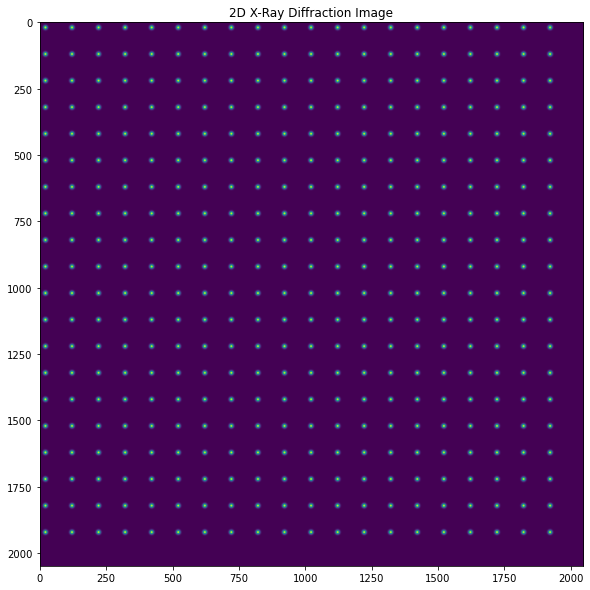

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Enter the number of the selected calibrant: 21
quartz


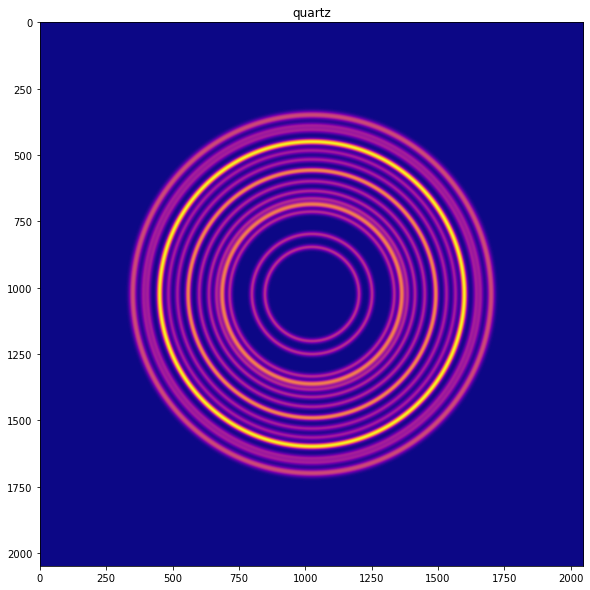

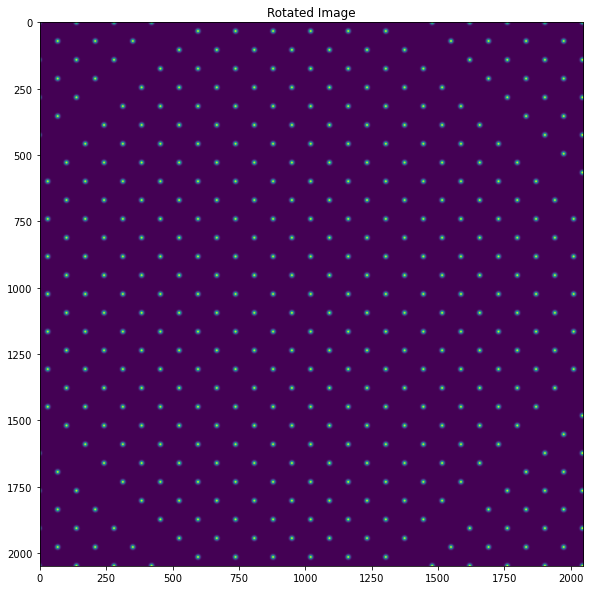

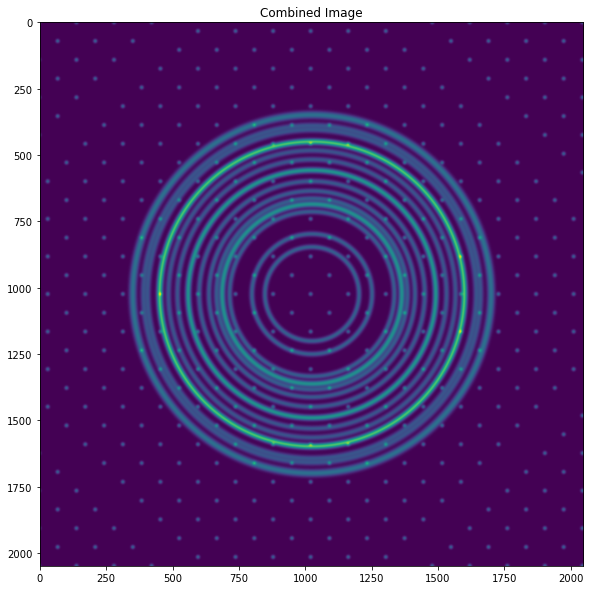

In [3]:
spots = tfdc.generate_2D_image(20, 5, 100, size = 40)
image = tfdc.plot_calibration_image(0.3, .5e-10, cmap = 'plasma')
rotated_spots = tfdc.rotate_image(spots, 45)
thin_film = tfdc.combine_image(image, rotated_spots)

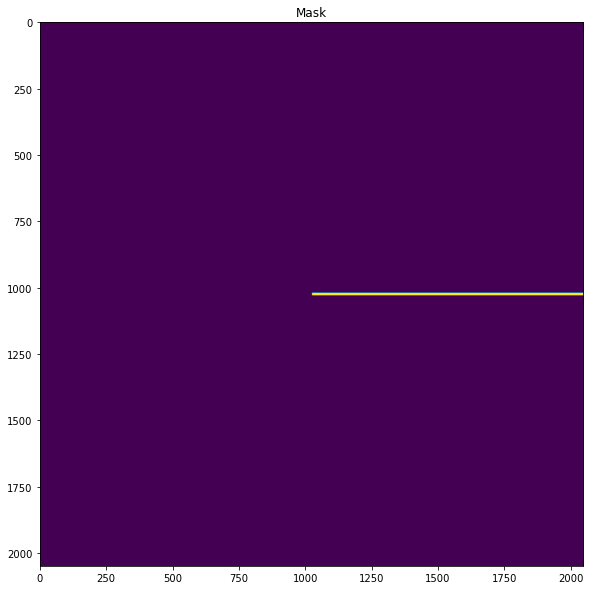

In [ ]:
mask_data = tfdc.create_numpy_array_mask(thin_film, 5)
data = tfdc.rotate_and_integrate(thin_film, 10, 0.3, .5e-10, resolution = 3000, mask = mask_data)